In [1]:
pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.3 MB 47 kB/s 
     |████████████████████████████████| 199 kB 38.4 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=b6b75dc726a8879281553a0bbd3d697e4747fda21659ddde7bdeeec048cb5a15
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark


In [9]:
import pandas as pd
from sklearn.datasets import load_iris
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
sc = SparkContext('local')
spark = SparkSession(sc)
df_iris = load_iris(as_frame=True)

In [10]:
pd_df_iris = pd.DataFrame(df_iris.data, columns = df_iris.feature_names)
pd_df_iris['target'] = pd.Series(df_iris.target)

In [11]:
spark_df_iris = spark.createDataFrame(pd_df_iris)
spark_df_iris = spark_df_iris.drop("target")

In [12]:
from pyspark.ml.feature import VectorAssembler
assemble=VectorAssembler(inputCols=[
'sepal length (cm)',
'sepal width (cm)',
'petal length (cm)',
'petal width (cm)'],outputCol = 'iris_features')

assembled_data=assemble.transform(spark_df_iris)

In [13]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

silhouette_scores=[]
evaluator = ClusteringEvaluator(featuresCol='iris_features', \
metricName='silhouette', distanceMeasure='squaredEuclidean')

for K in range(2,11):

    KMeans_=KMeans(featuresCol='iris_features', k=K)

    KMeans_fit=KMeans_.fit(assembled_data)

    KMeans_transform=KMeans_fit.transform(assembled_data) 

    evaluation_score=evaluator.evaluate(KMeans_transform)

    silhouette_scores.append(evaluation_score)

Text(0, 0.5, 'Silhouette Score')

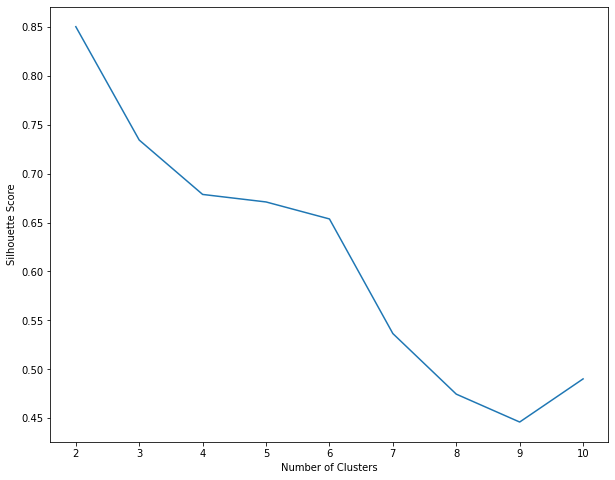

In [14]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(10,8))
ax.plot(range(2,11),silhouette_scores)
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Silhouette Score')

In [15]:
KMeans_=KMeans(featuresCol='iris_features', k=3) 
KMeans_Model=KMeans_.fit(assembled_data)
KMeans_Assignments=KMeans_Model.transform(assembled_data)

In [16]:
from pyspark.ml.feature import PCA as PCAml
pca = PCAml(k=2, inputCol="iris_features", outputCol="pca")
pca_model = pca.fit(assembled_data)
pca_transformed = pca_model.transform(assembled_data)

In [17]:
import numpy as np
x_pca = np.array(pca_transformed.rdd.map(lambda row: row.pca).collect())

In [18]:
cluster_assignment = np.array(KMeans_Assignments.rdd.map(lambda row: row.prediction).collect()).reshape(-1,1)


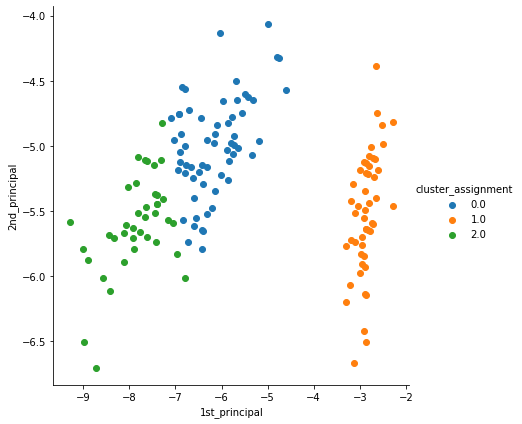

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

pca_data = np.hstack((x_pca,cluster_assignment))

pca_df = pd.DataFrame(data=pca_data, columns=("1st_principal", "2nd_principal","cluster_assignment"))
sns.FacetGrid(pca_df,hue="cluster_assignment", height=6).map(plt.scatter, '1st_principal', '2nd_principal' ).add_legend()

plt.show()